# Scatter Plot Visualization Data

Lets Try:

- Put all the LOI's on a single 2D plot
- Each point represents an LOI document
- The coordinates of the point are from some sort of clustering
- The color of the point is the area it was submitted to
- Mouse over gets you some "intersting" metadata:
   - The filename
   - The first 100 characters of text
   - An active link to the PDF

In order to do this we need to generate a bunch of data and write it out in a CSV file.

## Config

In [1]:
n_components = 2
n_word_summary = 100

## Setup

In [2]:
from config import text_file_info, word_vectors

# from collections import defaultdict
from pathlib import Path
import json

from sklearn.decomposition import PCA

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json

## Files

In [3]:
file_by_area = list(text_file_info())

In [4]:
data_filenames = [f[2] for f in file_by_area]
file_names = [f[0] for f in file_by_area]
file_areas = [f[1] for f in file_by_area]

## Abstract and title info

Load up our cached data

In [5]:
with open('../data/loi_info.json', 'r') as f:
    loi_summary_data_list = json.load(f)
loi_summary = {
    Path(e['file']).stem: {
        'title': e['title'],
        'abs': e['abstract']
    }
    for e in loi_summary_data_list
}

## 2D Coordinates from Text Contents

In [6]:
%%time
x, vectorizer = word_vectors(data_filenames)

CPU times: user 3.29 s, sys: 643 ms, total: 3.93 s
Wall time: 9.21 s


Now we do the Principle Component Analysis

In [7]:
pca = PCA(n_components)

In [8]:
%%time
loi_coordinates = pca.fit_transform(x.A)

CPU times: user 3.68 s, sys: 4.55 s, total: 8.23 s
Wall time: 1.11 s


Round them so we don't send too much data.

In [9]:
loi_coordinates = np.round(loi_coordinates, decimals=4)

Lets use `seaborn` to make a plot of this.

In [10]:
document_data = [
    {
        'x': x,
        'y': y,
        'name': str(name),
        'area': str(area),
        'url': f'https://www.snowmass21.org/docs/files/summaries/{area}/{name}.pdf',
        'title': loi_summary[str(name)]['title'],
        'abstract': loi_summary[str(name)]['abs'],
        'index': index
    }
    for index, ((x, y), name, area) in enumerate(zip(loi_coordinates, file_names, file_areas))
]
document_df = pd.DataFrame(document_data)

In [11]:
document_df

,x,y,name,area,url,title,abstract,index
0,-0.0723,0.0132,SNOWMASS21-AF-TOPIC0-001,AF,https://www.snowmass21.org/docs/files/summarie...,Gamma Factory,This contribution discusses the possibility of...,0
1,-0.1064,-0.0383,SNOWMASS21-AF0-015,AF,https://www.snowmass21.org/docs/files/summarie...,2020 snowmass Letter of Interest: High current...,The initial brightness of electron source dete...,1
2,-0.0293,0.0647,SNOWMASS21-AF0_AF0-091,AF,https://www.snowmass21.org/docs/files/summarie...,POTENTIAL FOR HIGH-ENERGY PHYSICS AT THE OAK R...,POTENTIAL FOR HIGH-ENERGY PHYSICS AT THE OAK R...,2
3,-0.1122,-0.0794,SNOWMASS21-AF0_AF0-215,AF,https://www.snowmass21.org/docs/files/summarie...,Plasma Processing for In-Situ Field Emission M...,and more powerful particle accelerators which ...,3
4,-0.1335,-0.0564,SNOWMASS21-AF0_AF0-229,AF,https://www.snowmass21.org/docs/files/summarie...,Letter of Interest for Snowmass2021,applications the couplers are required to tran...,4
...,...,...,...,...,...,...,...,...
1509,-0.0053,-0.0047,SNOWMASS21-UF0_UF0_Garcia-Sciveres-001,UF,https://www.snowmass21.org/docs/files/summarie...,Snowmass2021 Letter of Interest: Classificatio...,development of new underground space raises qu...,1509
1510,0.0063,0.0687,SNOWMASS21-UF1_UF4-RF4_RF3_ODonnell-007,UF,https://www.snowmass21.org/docs/files/summarie...,KURF: The Kimballton Underground Research Faci...,: The Kimballton Underground Research Facility...,1510
1511,0.1692,-0.0093,SNOWMASS21-UF4_UF3-NF5_NF6-CF1_CF0-IF3_IF0-Com...,UF,https://www.snowmass21.org/docs/files/summarie...,Snowmass2021 - Letter of Interest Advanced Ger...,: Next-generation dark matter (DM) experiments...,1511
1512,0.0813,0.0255,SNOWMASS21-UF6_UF0-NF10_NF0-RF4_RF0-CF1_CF0-IF...,UF,https://www.snowmass21.org/docs/files/summarie...,Snowmass2021 - Letter of Interest Solution-min...,: The oil and gas storage industry has very we...,1512


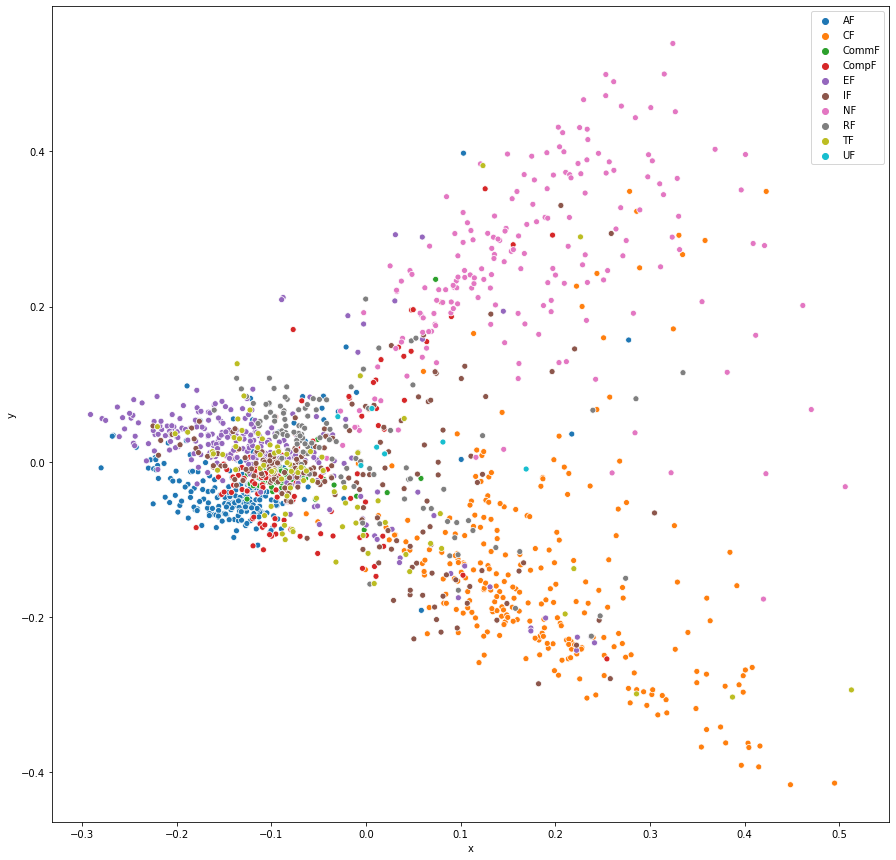

In [12]:
plt.figure(figsize=(15,15))
g = sns.scatterplot(x='x', y='y', hue=document_df.area.to_list(), data=document_df)

## Writing out the data

In [13]:
document_df.to_csv('../web/data/loi-data.csv')

## Word Frequency and Importance Data

Generate the JSON file for word importance. This allows one to identify which documents use which words, and what their relative importance is.

In [14]:
terms = vectorizer.get_feature_names()

In [15]:
%%time
term_usage_info = {}
for t_index, t in enumerate(terms):
    non_zero_index = np.nonzero(x[:,t_index])[0]
    non_zero_weight = np.take(x[:,t_index].toarray(), non_zero_index)
    non_zero_weight = np.round(non_zero_weight, decimals=4)
    doc_word_usage = {int(i): wt for i,wt in zip(non_zero_index, non_zero_weight)}
    term_usage_info[t] = doc_word_usage

CPU times: user 21.7 s, sys: 0 ns, total: 21.7 s
Wall time: 21.7 s


In [16]:
len(term_usage_info['mathusla'])

19

In [17]:
with open('../web/data/term_data.json', 'wt') as fout:
    json.dump(term_usage_info, fout)